# Online Retail Sales & Customer Analytics using PySpark


*  Objective:
Analyze online retail transaction data to understand sales trends, customer behavior, revenue concentration, and product return patterns, and derive actionable business insights.


*   Dataset source (Kaggle – Online Retail Dataset)




**Dataset Overview**

In [4]:
import pandas as pd

# Read Excel
df_excel = pd.read_excel("Online Retail.xlsx")

# Quick check
df_excel.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
df_excel.to_csv("online_retail.csv", index=False)
print("Saved as 'online_retail.csv'")

Saved as 'online_retail.csv'


In [6]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("OnlineRetailAnalysis").getOrCreate()

In [8]:
df = spark.read.csv("online_retail.csv", header=True, inferSchema=True)

df.printSchema()
df.show(20)

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: double (nullable = true)
 |-- Country: string (nullable = true)

+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|2010-12-01 08:26:00|     2.55|   17850.0|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|2010-12-01 08:26:00|     2.75|   17850.0|United Kingdom|
|   536365| 

In [9]:
print("Number of rows:", df.count())
print("Number of columns:", len(df.columns))

Number of rows: 541909
Number of columns: 8


In [10]:
df.dtypes

[('InvoiceNo', 'string'),
 ('StockCode', 'string'),
 ('Description', 'string'),
 ('Quantity', 'int'),
 ('InvoiceDate', 'timestamp'),
 ('UnitPrice', 'double'),
 ('CustomerID', 'double'),
 ('Country', 'string')]

In [11]:
df.describe().show()

+-------+------------------+------------------+--------------------+------------------+-----------------+------------------+-----------+
|summary|         InvoiceNo|         StockCode|         Description|          Quantity|        UnitPrice|        CustomerID|    Country|
+-------+------------------+------------------+--------------------+------------------+-----------------+------------------+-----------+
|  count|            541909|            541909|              540455|            541909|           541909|            406829|     541909|
|   mean|  559965.752026781|27623.240210938104|             20713.0|  9.55224954743324| 4.61111362608298|15287.690570239585|       NULL|
| stddev|13428.417280803813|16799.737628427752|                NULL|218.08115785023477|96.75985306117967|1713.6003033215982|       NULL|
|    min|            536365|             10002| 4 PURPLE FLOCK D...|            -80995|        -11062.06|           12346.0|  Australia|
|    max|           C581569|             

In [12]:
print("Unique values:")
print(f"  • Unique Invoices: {df.select('InvoiceNo').distinct().count():,}")
print(f"  • Unique Customers: {df.select('CustomerID').distinct().count():,}")
print(f"  • Unique Products: {df.select('Description').distinct().count():,}")
print(f"  • Unique Countries: {df.select('Country').distinct().count():,}")


Unique values:
  • Unique Invoices: 25,900
  • Unique Customers: 4,373
  • Unique Products: 4,224
  • Unique Countries: 38


**Data Cleaning & Preparation**

In [13]:
from pyspark.sql.functions import count, when, col

df.select([count(when(col(c).isNull(), c)).alias(c + "_nulls") for c in df.columns]).show()

+---------------+---------------+-----------------+--------------+-----------------+---------------+----------------+-------------+
|InvoiceNo_nulls|StockCode_nulls|Description_nulls|Quantity_nulls|InvoiceDate_nulls|UnitPrice_nulls|CustomerID_nulls|Country_nulls|
+---------------+---------------+-----------------+--------------+-----------------+---------------+----------------+-------------+
|              0|              0|             1454|             0|                0|              0|          135080|            0|
+---------------+---------------+-----------------+--------------+-----------------+---------------+----------------+-------------+



*show count of nulls for each column individually*

In [14]:
from pyspark.sql.functions import col, round, to_timestamp, year, month, dayofmonth, hour
df_clean = df.dropna(subset=["Description", "CustomerID"])
df_clean = df_clean.filter(~col("InvoiceNo").startswith("C"))
df_clean = df_clean.filter((col("Quantity") > 0) & (col("UnitPrice") > 0))
df_clean = df_clean.withColumn("TotalPrice", round(col("Quantity") * col("UnitPrice"), 2))
df_clean = df_clean.withColumn("InvoiceTS", to_timestamp(col("InvoiceDate")))
df_clean = df_clean.withColumn("Year", year(col("InvoiceTS")))
df_clean = df_clean.withColumn("Month", month(col("InvoiceTS")))
df_clean = df_clean.withColumn("Day", dayofmonth(col("InvoiceTS")))
df_clean = df_clean.withColumn("Hour", hour(col("InvoiceTS")))
df_clean = df_clean.drop_duplicates()

In [15]:
print("Original row count:", df.count())
print("Cleaned row count:", df_clean.count())


Original row count: 541909
Cleaned row count: 392692


In [16]:
df_clean.select("InvoiceNo","CustomerID","Quantity","UnitPrice","TotalPrice","Year","Month").show(5)


+---------+----------+--------+---------+----------+----+-----+
|InvoiceNo|CustomerID|Quantity|UnitPrice|TotalPrice|Year|Month|
+---------+----------+--------+---------+----------+----+-----+
|   536373|   17850.0|       6|     1.06|      6.36|2010|   12|
|   536390|   17511.0|      96|     1.25|     120.0|2010|   12|
|   536423|   18085.0|       8|     3.75|      30.0|2010|   12|
|   536527|   12662.0|      10|     1.95|      19.5|2010|   12|
|   536560|   13093.0|      20|     6.75|     135.0|2010|   12|
+---------+----------+--------+---------+----------+----+-----+
only showing top 5 rows


In [22]:
from pyspark.sql.functions import sum, avg, countDistinct


In [24]:
overall_metrics = df_clean.agg(
    sum("TotalPrice").alias("Total_Revenue"),
    avg("TotalPrice").alias("Average_Transaction_Value"),
    sum("Quantity").alias("Total_Quantity_Sold"),
    countDistinct("InvoiceNo").alias("Total_Transactions"),
    countDistinct("CustomerID").alias("Total_Customers")
).collect()[0]

In [26]:
# Print metrics
print("\n OVERALL METRICS:")
print(f"  • Total Revenue: ${overall_metrics['Total_Revenue']:,.2f}")
print(f"  • Average Transaction Value: ${overall_metrics['Average_Transaction_Value']:,.2f}")
print(f"  • Total Quantity Sold: {overall_metrics['Total_Quantity_Sold']:,.0f}")
print(f"  • Total Transactions: {overall_metrics['Total_Transactions']:,}")
print(f"  • Total Customers: {overall_metrics['Total_Customers']:,}")



 OVERALL METRICS:
  • Total Revenue: $8,887,208.89
  • Average Transaction Value: $22.63
  • Total Quantity Sold: 5,152,002
  • Total Transactions: 18,532
  • Total Customers: 4,338


**Exploratory Data Analysis**

In [18]:
# 1. Monthly revenue trend
df_clean.groupBy("Year", "Month").sum("TotalPrice").orderBy("Year", "Month").show(30)

+----+-----+------------------+
|Year|Month|   sum(TotalPrice)|
+----+-----+------------------+
|2010|   12| 570422.7300000084|
|2011|    1| 568101.3100000045|
|2011|    2|446084.92000000237|
|2011|    3|   594081.76000001|
|2011|    4| 468374.3300000018|
|2011|    5| 677355.1500000026|
|2011|    6| 660046.0500000054|
|2011|    7| 598962.9000000022|
|2011|    8| 644051.0400000036|
|2011|    9| 950690.2000000228|
|2011|   10|1035642.4500000356|
|2011|   11|1156205.6100000418|
|2011|   12| 517190.4400000038|
+----+-----+------------------+



*We can observe that the total revenue generally increased towards the end of 2011, with the highest revenues in October and November, which aligns with holiday shopping trends.*

In [19]:
# 2.Monthly Average Order Value (AOV)
df_clean.groupBy("Year", "Month", "InvoiceNo")\
    .sum("TotalPrice")\
    .groupBy("Year", "Month")\
    .avg("sum(TotalPrice)")\
    .orderBy("Year", "Month")\
    .show()


+----+-----+--------------------+
|Year|Month|avg(sum(TotalPrice))|
+----+-----+--------------------+
|2010|   12|   407.4448071428572|
|2011|    1|   575.5839007092186|
|2011|    2|   447.4272016048143|
|2011|    3|   449.7212414837247|
|2011|    4|   407.6364926022629|
|2011|    5|  435.59816720257106|
|2011|    6|  473.83061737257765|
|2011|    7|  450.00969196093297|
|2011|    8|   503.1648750000004|
|2011|    9|   541.7038176638185|
|2011|   10|   536.8804821150849|
|2011|   11|   435.1545389537074|
|2011|   12|    664.769203084833|
+----+-----+--------------------+





*   Monthly Average Order Value (AOV)
*   The monthly average order value analysis reveals clear seasonality in customer spending. Order values peak during the beginning and end of the year, with December showing the highest average order value, likely driven by holiday demand. Mid-year months display relatively stable spending patterns, indicating consistent baseline demand.



In [20]:
# 3. Hour-of-day ordering behavior
df_clean.groupBy("Hour").sum("TotalPrice").orderBy("Hour").show()

+----+------------------+
|Hour|   sum(TotalPrice)|
+----+------------------+
|   6|              4.25|
|   7|31059.209999999992|
|   8| 281997.7899999992|
|   9| 842392.3400000001|
|  10|1259267.5900000124|
|  11|1101177.6000000313|
|  12| 1373695.390000028|
|  13|1168724.2000000398|
|  14| 991992.8200000415|
|  15| 963559.6800000306|
|  16| 467380.5600000004|
|  17|233811.58999999886|
|  18|104744.99000000002|
|  19|48568.400000000154|
|  20|18832.479999999996|
+----+------------------+



*Most orders were placed between 10 AM and 3 PM.*

In [41]:
# Country wise analysis

from pyspark.sql.functions import sum, countDistinct, col, round
from pyspark.sql.window import Window
country_sales = df_clean.groupBy("Country").agg(
    sum("TotalPrice").alias("TotalRevenue"),
    countDistinct("CustomerID").alias("UniqueCustomers"),
    countDistinct("InvoiceNo").alias("TotalOrders"),
    sum("Quantity").alias("TotalQuantity")
)


In [36]:
total_revenue = country_sales.agg(
    sum("TotalRevenue").alias("OverallRevenue")
).collect()[0]["OverallRevenue"]


In [40]:
from pyspark.sql.functions import row_number

window_spec = Window.orderBy(col("TotalRevenue").desc())

country_sales = country_sales \
    .withColumn("Revenue_%", round((col("TotalRevenue") / total_revenue) * 100, 2)) \
    .withColumn("Rank", row_number().over(window_spec))
country_sales = country_sales.withColumn(
    "Rank",
    row_number().over(window_spec)
)
country_sales \
    .orderBy("Rank") \
    .select("Rank", "Country", "TotalRevenue", "Revenue_%", "UniqueCustomers") \
    .show(10, truncate=False)


+----+--------------+------------------+---------+---------------+
|Rank|Country       |TotalRevenue      |Revenue_%|UniqueCustomers|
+----+--------------+------------------+---------+---------------+
|1   |United Kingdom|7285024.640000011 |81.97    |3920           |
|2   |Netherlands   |285446.3399999995 |3.21     |9              |
|3   |EIRE          |265262.45999999985|2.98     |3              |
|4   |Germany       |228678.40000000002|2.57     |94             |
|5   |France        |208934.30999999997|2.35     |87             |
|6   |Australia     |138453.81000000003|1.56     |9              |
|7   |Spain         |61558.55999999997 |0.69     |30             |
|8   |Switzerland   |56443.95          |0.64     |21             |
|9   |Belgium       |41196.34          |0.46     |25             |
|10  |Sweden        |38367.829999999994|0.43     |8              |
+----+--------------+------------------+---------+---------------+
only showing top 10 rows


*The UK is by far the largest market,, followed by the Netherlands and Germany.
*Also UK has most number of customers.*

In [27]:
# 5. Data by country, computes average quantity and average revenue per transaction, and ranks countries based on average revenue.
df_clean.groupBy("Country")\
    .agg({"Quantity":"avg", "TotalPrice":"avg"})\
    .orderBy(col("avg(TotalPrice)").desc())\
    .show()


+--------------------+------------------+------------------+
|             Country|   avg(TotalPrice)|     avg(Quantity)|
+--------------------+------------------+------------------+
|         Netherlands| 121.0031114879184| 84.93471810089021|
|           Australia|117.23438611346316| 71.03386960203217|
|               Japan|116.56190031152649| 81.04672897196262|
|           Singapore|  95.8526576576577| 23.60810810810811|
|              Sweden| 85.26184444444442| 80.17333333333333|
|             Denmark|49.882473684210495| 21.67105263157895|
|           Lithuania| 47.45885714285714| 18.62857142857143|
|             Lebanon|37.641777777777776| 8.577777777777778|
|                EIRE| 36.70944644339871| 19.39288679767506|
|              Brazil|           35.7375|            11.125|
|              Norway| 33.76791783380018|18.054154995331466|
|      Czech Republic|           33.0696|             26.84|
|             Finland| 32.91398540145985|15.626277372262773|
|              Greece| 3



* Data by country, computes average quantity and average revenue per transaction, and ranks countries based on average revenue.


1.  High average order value countries

*  Countries like Netherlands, Australia, Japan, Singapore, and Sweden have the highest average order value.

* This indicates:
Bulk purchases
,Higher-priced products
,Strong B2B or wholesale-like behavior



2.   Quantity vs price-driven markets


*  Countries like Netherlands, Australia, Japan, Singapore, and Sweden have the highest average order value.
*  Singapore → high value but lower quantity
→ Fewer items, but expensive purchases

*  Sweden → very high quantity with strong revenue
→ Bulk buying behavior


3.  Lower-value but consistent markets


*  Countries like Austria, Israel, UAE, Channel Islands
*  Lower average transaction value


*   Likely:

    Smaller baskets

    Price-sensitive customers

    Retail-style buying




4.  Strategic implication


*   High-value countries → focus on retention & premium offerings
*   Lower-value countries → focus on volume growth & promotions












In [28]:
# 5.Customize inventory by region.
from pyspark.sql.functions import row_number
from pyspark.sql.window import Window

windowSpec = Window.partitionBy("Country").orderBy(col("sum(Quantity)").desc())

top_products_country = df_clean.groupBy("Country", "Description")\
    .sum("Quantity")\
    .withColumn("rank", row_number().over(windowSpec))\
    .filter(col("rank") <= 3)

top_products_country.orderBy("Country", "rank").show(20, truncate=False)


+---------------+-----------------------------------+-------------+----+
|Country        |Description                        |sum(Quantity)|rank|
+---------------+-----------------------------------+-------------+----+
|Australia      |MINI PAINT SET VINTAGE             |2952         |1   |
|Australia      |RABBIT NIGHT LIGHT                 |1884         |2   |
|Australia      |RED  HARMONICA IN BOX              |1704         |3   |
|Austria        |SET 12 KIDS COLOUR  CHALK STICKS   |288          |1   |
|Austria        |MINI JIGSAW PURDEY                 |240          |2   |
|Austria        |PACK OF 6 SWEETIE GIFT BOXES       |144          |3   |
|Bahrain        |ICE CREAM SUNDAE LIP GLOSS         |96           |1   |
|Bahrain        |DOUGHNUT LIP GLOSS                 |60           |2   |
|Bahrain        |GROW A FLYTRAP OR SUNFLOWER IN TIN |24           |3   |
|Belgium        |PACK OF 72 RETROSPOT CAKE CASES    |480          |1   |
|Belgium        |ROUND SNACK BOXES SET OF4 WOODLAND





*Top 3 best-selling products in each country based on total quantity sold.*












**Returns Analysis**

In [29]:
df_raw = spark.read.csv("online_retail.csv", header=True, inferSchema=True)
df_returns = df_raw.filter(col("InvoiceNo").startswith("C"))
df_returns.groupBy("Description")\
    .sum("Quantity")\
    .orderBy(col("sum(Quantity)").asc())\
    .show()




+--------------------+-------------+
|         Description|sum(Quantity)|
+--------------------+-------------+
|PAPER CRAFT , LIT...|       -80995|
|MEDIUM CERAMIC TO...|       -74494|
|ROTATING SILVER A...|        -9376|
|              Manual|        -4066|
|FAIRY CAKE FLANNE...|        -3150|
|PINK BLUE FELT CR...|        -2617|
|WHITE HANGING HEA...|        -2578|
|GIN + TONIC DIET ...|        -2030|
|   HERB MARKER BASIL|        -1527|
|FELTCRAFT DOLL MOLLY|        -1447|
|TEA TIME PARTY BU...|        -1424|
|PAPER POCKET TRAV...|        -1385|
|WORLD WAR 2 GLIDE...|        -1200|
|            Discount|        -1194|
|COLOUR GLASS. STA...|        -1174|
|JUMBO BAG RED RET...|        -1115|
| HOME SWEET HOME MUG|        -1052|
|PANTRY CHOPPING B...|         -946|
|PLACE SETTING WHI...|         -890|
|FELTCRAFT BUTTERF...|         -877|
+--------------------+-------------+
only showing top 20 rows


In [30]:
from pyspark.sql.functions import when

df_buckets = df_clean.withColumn("OrderBucket", when(col("TotalPrice") < 50, "<50")
    .when(col("TotalPrice").between(50, 100), "50-100")
    .when(col("TotalPrice").between(101, 500), "101-500")
    .otherwise(">500"))

df_buckets.groupBy("OrderBucket").count().orderBy("OrderBucket").show()


+-----------+------+
|OrderBucket| count|
+-----------+------+
|    101-500| 10533|
|     50-100| 15560|
|        <50|365482|
|       >500|  1117|
+-----------+------+



Most orders are low-value or mid-value.

**Customer Contribution & Pareto Analysis**

In [31]:
# First, total revenue
total_revenue = df_clean.agg({"TotalPrice": "sum"}).collect()[0][0]

# Revenue per customer
customer_revenue = df_clean.groupBy("CustomerID")\
    .sum("TotalPrice")\
    .orderBy(col("sum(TotalPrice)").desc())

# Add cumulative revenue %
from pyspark.sql.functions import sum as _sum, col

windowSpecRev = Window.orderBy(col("sum(TotalPrice)").desc())
customer_revenue = customer_revenue.withColumn(
    "cum_revenue", _sum("sum(TotalPrice)").over(windowSpecRev)
)

customer_revenue = customer_revenue.withColumn(
    "cum_revenue_pct", (col("cum_revenue") / total_revenue) * 100
)

customer_revenue.show(20)


+----------+------------------+------------------+------------------+
|CustomerID|   sum(TotalPrice)|       cum_revenue|   cum_revenue_pct|
+----------+------------------+------------------+------------------+
|   14646.0| 280206.0199999995| 280206.0199999995| 3.152913625280765|
|   18102.0|259657.30000000005| 539863.3199999996| 6.074610450615269|
|   17450.0|194390.78999999998| 734254.1099999996| 8.261920239391731|
|   16446.0|          168472.5| 902726.6099999996|10.157594146523044|
|   14911.0|143711.16999999975|1046437.7799999993|11.774650432458799|
|   12415.0|124914.53000000004|1171352.3099999994|13.180204544510152|
|   14156.0|117210.08000000007|1288562.3899999994|14.499067209388835|
|   17511.0|          91062.38|1379624.7699999996| 15.52371264224747|
|   16029.0| 80850.83999999998|1460475.6099999996| 16.43345653372916|
|   12346.0|           77183.6|1537659.2099999997| 17.30193617627296|
|   16684.0|          66653.56|1604312.7699999998|18.051930475101617|
|   14096.0| 65164.7

In [ ]:
from pyspark.sql.functions import col

# Total number of customers
total_customers = customer_revenue.count()

# Customers contributing up to 80% revenue
customers_80 = customer_revenue \
    .filter(col("cum_revenue_pct") <= 80) \
    .count()

# Percentage of customers
percentage_customers_80 = (customers_80 / total_customers) * 100

percentage_customers_80


In [ ]:
from pyspark.sql.functions import monotonically_increasing_id

# Add running customer count
customer_revenue_pareto = customer_revenue \
    .withColumn("customer_rank", monotonically_increasing_id() + 1)

# Convert rank to percentage
customer_revenue_pareto = customer_revenue_pareto.withColumn(
    "customer_pct",
    (col("customer_rank") / total_customers) * 100
)

customer_revenue_pareto.select(
    "customer_pct", "cum_revenue_pct"
).orderBy("customer_pct")


In [ ]:
import matplotlib.pyplot as plt

pareto_pd = customer_revenue_pareto \
    .select("customer_pct", "cum_revenue_pct") \
    .orderBy("customer_pct") \
    .toPandas()

plt.figure()
plt.plot(pareto_pd["customer_pct"], pareto_pd["cum_revenue_pct"])
plt.xlabel("Percentage of Customers")
plt.ylabel("Cumulative Revenue Percentage")
plt.title("Pareto Curve (Customer Revenue Distribution)")
plt.show()




*   80% revenue comes from ~26% of customers.
*   Prove Pareto Principle (26% customers = ~80% revenue).
*   Pareto analysis shows that approximately 26% of customers contribute to 80% of total revenue, indicating a moderately concentrated but well-diversified customer base rather than a strict 80–20 distribution.




## Analyze customer purchasing behavior

### Subtask:
RFM Analysis


In [32]:
from pyspark.sql.functions import datediff, max, countDistinct, sum, lit, col, round, to_timestamp, year, month, dayofmonth, hour


# Calculate Recency
recency_df = df_clean.groupBy("CustomerID").agg(
    datediff(lit("2011-12-10"), max("InvoiceDate")).alias("Recency")
)

# Calculate Frequency
frequency_df = df_clean.groupBy("CustomerID").agg(
    countDistinct("InvoiceNo").alias("Frequency")
)

# Calculate MonetaryValue
monetary_df = df_clean.groupBy("CustomerID").agg(
    sum("TotalPrice").alias("MonetaryValue")
)

# Join the three dataframes
rfm_df = recency_df.join(frequency_df, on="CustomerID", how="inner")
rfm_df = rfm_df.join(monetary_df, on="CustomerID", how="inner")

# Display the RFM DataFrame
rfm_df.show()

+----------+-------+---------+------------------+
|CustomerID|Recency|Frequency|     MonetaryValue|
+----------+-------+---------+------------------+
|   13094.0|     22|       12|1927.3199999999997|
|   13973.0|    288|        1|             264.7|
|   17884.0|      4|        4| 695.0699999999999|
|   13533.0|    183|        3|269.09000000000003|
|   13918.0|     50|        2|1212.8399999999997|
|   17267.0|    128|        2|317.20000000000005|
|   14768.0|     18|        2|             192.6|
|   15776.0|    134|        1|241.62000000000003|
|   13956.0|      6|        5|1019.2699999999995|
|   14473.0|     75|        2|            234.34|
|   18114.0|    291|        1|220.10000000000002|
|   12493.0|    166|        2|            433.74|
|   14024.0|    122|        2|             327.7|
|   16596.0|     16|        2|250.14999999999998|
|   14285.0|     22|        4|           1910.01|
|   16561.0|      6|        2| 511.1200000000001|
|   17633.0|     32|        4|1324.8399999999997|


In [34]:
from pyspark.sql.functions import datediff, max, countDistinct, sum, lit, col, round, to_timestamp, year, month, dayofmonth, hour, ntile
from pyspark.sql.window import Window

# Window specs
r_window = Window.orderBy(col("Recency").desc())
f_window = Window.orderBy(col("Frequency"))
m_window = Window.orderBy(col("MonetaryValue"))

# RFM scoring
rfm_scored = rfm_df \
    .withColumn("R_Score", ntile(5).over(r_window)) \
    .withColumn("F_Score", ntile(5).over(f_window)) \
    .withColumn("M_Score", ntile(5).over(m_window))
rfm_scored = rfm_scored.withColumn(
    "RFM_Score",
    col("R_Score") * 100 + col("F_Score") * 10 + col("M_Score"))

In [42]:
from pyspark.sql.functions import when
rfm_segmented = rfm_scored.withColumn(
    "Customer_Segment",
    when((col("R_Score") >= 4) & (col("F_Score") >= 4) & (col("M_Score") >= 4), "Champions")
    .when((col("R_Score") >= 3) & (col("F_Score") >= 3), "Loyal Customers")
    .when((col("R_Score") >= 4) & (col("F_Score") <= 2), "New Customers")
    .when((col("R_Score") <= 2) & (col("F_Score") >= 3), "At Risk")
    .when((col("R_Score") <= 2) & (col("F_Score") <= 2), "Lost Customers")
    .otherwise("Potential")
)


In [44]:
rfm_segmented.select(
    "CustomerID",
    "Recency",
    "Frequency",
    "MonetaryValue",
    "R_Score",
    "F_Score",
    "M_Score",
    "RFM_Score",
    "Customer_Segment"
).show()


+----------+-------+---------+-------------+-------+-------+-------+---------+----------------+
|CustomerID|Recency|Frequency|MonetaryValue|R_Score|F_Score|M_Score|RFM_Score|Customer_Segment|
+----------+-------+---------+-------------+-------+-------+-------+---------+----------------+
|   16738.0|    298|        1|         3.75|      1|      1|      1|      111|  Lost Customers|
|   14792.0|     64|        1|          6.2|      3|      2|      1|      321|       Potential|
|   16454.0|     45|        2|          6.9|      3|      3|      1|      331| Loyal Customers|
|   17956.0|    250|        1|        12.75|      1|      1|      1|      111|  Lost Customers|
|   16878.0|     85|        1|         13.3|      2|      2|      1|      221|  Lost Customers|
|   15823.0|    373|        1|         15.0|      1|      1|      1|      111|  Lost Customers|
|   17763.0|    264|        1|         15.0|      1|      1|      1|      111|  Lost Customers|
|   13307.0|    121|        1|         1



*  RFM analysis was performed to quantify customer behavior based on recency of purchase, frequency of transactions, and total monetary value. Customers with low recency, high frequency, and high monetary value represent the most valuable segment, while customers with high recency and low frequency are at risk of churn.




**Segment-wise revenue contribution**

In [45]:
from pyspark.sql.functions import sum as _sum

segment_revenue = rfm_segmented.groupBy("Customer_Segment") \
    .agg(_sum("MonetaryValue").alias("Segment_Revenue")) \
    .orderBy(col("Segment_Revenue").desc())

segment_revenue.show()


+----------------+------------------+
|Customer_Segment|   Segment_Revenue|
+----------------+------------------+
|       Champions| 5835434.889999999|
| Loyal Customers|1512314.4499999995|
|         At Risk| 766936.0400000004|
|  Lost Customers| 579956.3899999999|
|       Potential|117875.77999999997|
|   New Customers| 74691.34000000001|
+----------------+------------------+



In [46]:
from pyspark.sql.functions import count, sum as _sum

segment_kpis = rfm_segmented.groupBy("Customer_Segment").agg(
    count("CustomerID").alias("Customers"),
    _sum("MonetaryValue").alias("Total_Revenue")
)

total_customers = rfm_segmented.count()
total_revenue = rfm_segmented.agg(_sum("MonetaryValue")).collect()[0][0]

segment_kpis = segment_kpis \
    .withColumn("Customer_%", round(col("Customers") / total_customers * 100, 2)) \
    .withColumn("Revenue_%", round(col("Total_Revenue") / total_revenue * 100, 2)) \
    .orderBy(col("Total_Revenue").desc())

segment_kpis.show()


+----------------+---------+------------------+----------+---------+
|Customer_Segment|Customers|     Total_Revenue|Customer_%|Revenue_%|
+----------------+---------+------------------+----------+---------+
|       Champions|     1000| 5835434.889999999|     23.05|    65.66|
| Loyal Customers|     1075|1512314.4499999995|     24.78|    17.02|
|         At Risk|      527| 766936.0400000004|     12.15|     8.63|
|  Lost Customers|     1209| 579956.3899999999|     27.87|     6.53|
|       Potential|      295|117875.77999999997|       6.8|     1.33|
|   New Customers|      232| 74691.34000000001|      5.35|     0.84|
+----------------+---------+------------------+----------+---------+



*RFM Segment Insights*

*   Champions (23.05%) generate 65.66% of total revenue, confirming a strong Pareto effect.
*   Retention of this segment is critical for revenue stability.


*   Loyal Customers (24.78%) contribute 17.02% of revenue and show strong repeat behavior.

*   They are the best candidates for conversion into Champions.
*  At Risk customers (12.15%) still generate 8.63% of revenue, despite declining engagement.


* Targeted reactivation can recover meaningful revenue.


* Lost Customers (27.87%) contribute only 6.53% of revenue, despite being the largest group.


* Low priority for broad marketing efforts.


* New + Potential customers (12.15%) contribute just 2.17% of revenue.


* Focus on onboarding to increase future lifetime value.





## Visualize the data

### Subtask:
Create visualizations such as time series plots of total revenue, bar charts of top countries by revenue, and bar charts of top products by quantity sold.


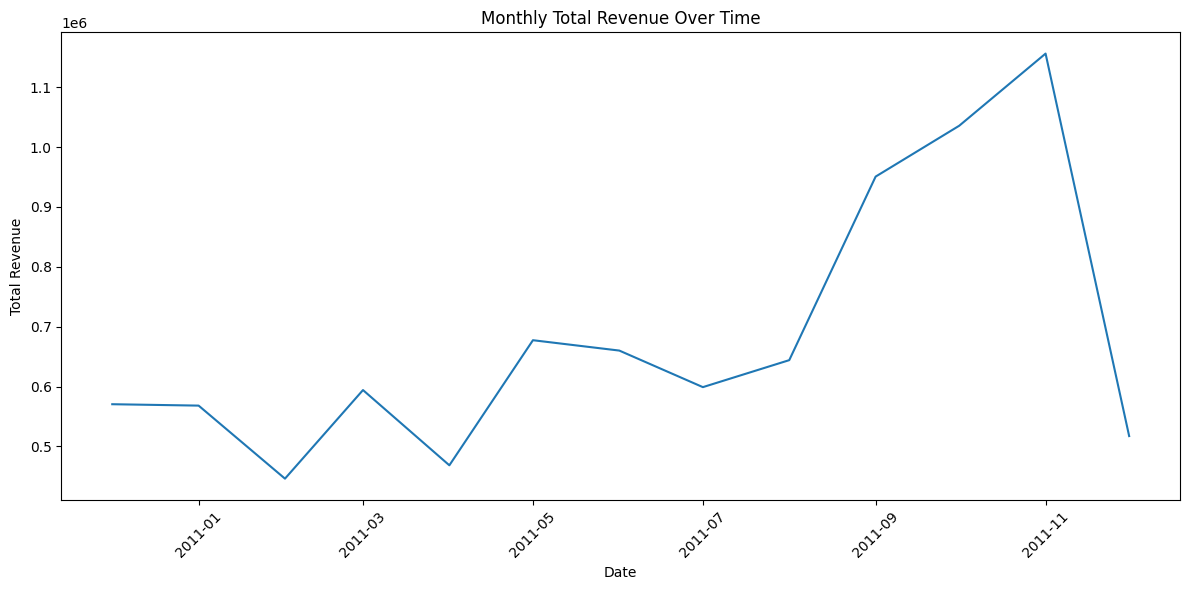

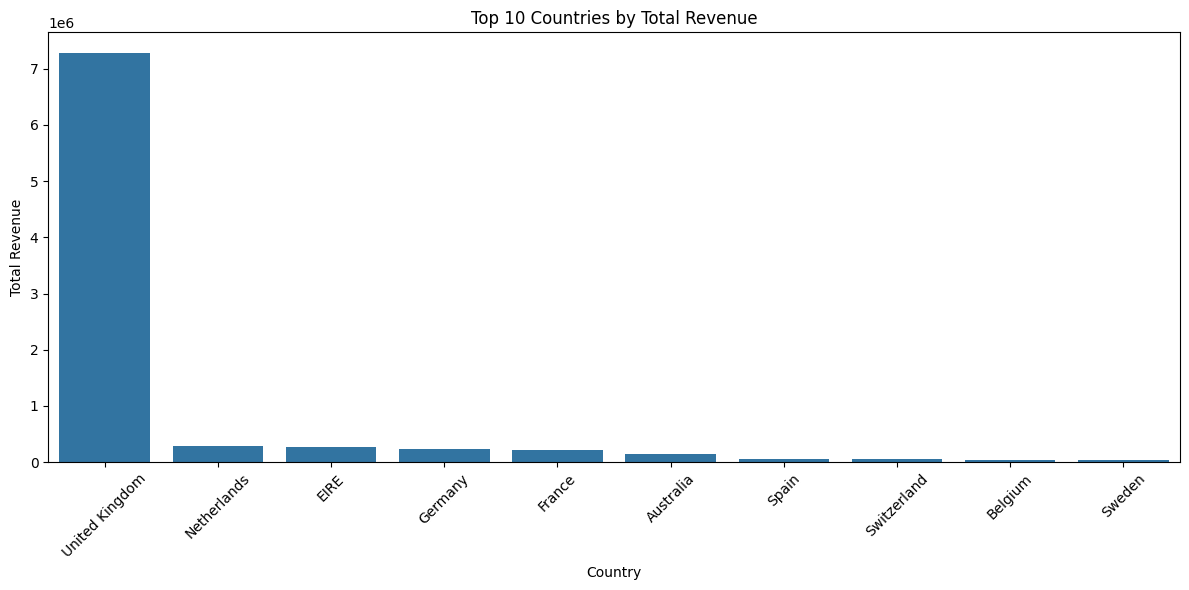

In [47]:
from pyspark.sql.functions import sum as spark_sum
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Calculate total revenue per month and year and collect into pandas
monthly_revenue = df_clean.groupBy("Year", "Month").agg(spark_sum("TotalPrice").alias("TotalRevenue")).orderBy("Year", "Month").collect()
monthly_revenue_pd = pd.DataFrame(monthly_revenue, columns=["Year", "Month", "TotalRevenue"])
monthly_revenue_pd["Date"] = pd.to_datetime(monthly_revenue_pd["Year"].astype(str) + "-" + monthly_revenue_pd["Month"].astype(str))

# 2. Plot time series of monthly total revenue
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_revenue_pd, x="Date", y="TotalRevenue")
plt.title("Monthly Total Revenue Over Time")
plt.xlabel("Date")
plt.ylabel("Total Revenue")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3. Calculate total revenue for each country and collect into pandas
country_revenue = df_clean.groupBy("Country").agg(spark_sum("TotalPrice").alias("TotalRevenue")).orderBy(col("TotalRevenue").desc()).collect()
country_revenue_pd = pd.DataFrame(country_revenue, columns=["Country", "TotalRevenue"])

# 4. Create a bar chart showing total revenue for top countries
plt.figure(figsize=(12, 6))
sns.barplot(data=country_revenue_pd.head(10), x="Country", y="TotalRevenue")
plt.title("Top 10 Countries by Total Revenue")
plt.xlabel("Country")
plt.ylabel("Total Revenue")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Reasoning**:
Calculate the total quantity sold for each product description, sort the results in descending order, collect into a pandas DataFrame, and plot a bar chart for the top products.



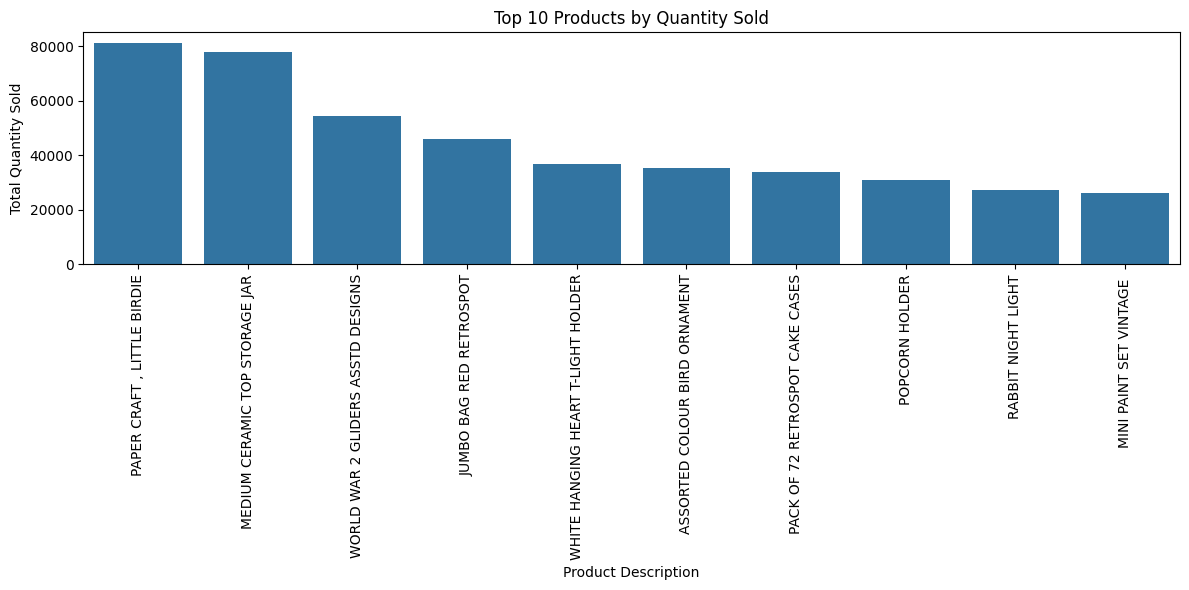

In [48]:
# 5. Calculate total quantity sold for each product description and collect into pandas
product_quantity = df_clean.groupBy("Description").agg(spark_sum("Quantity").alias("TotalQuantity")).orderBy(col("TotalQuantity").desc()).collect()
product_quantity_pd = pd.DataFrame(product_quantity, columns=["Description", "TotalQuantity"])

# 6. Generate a bar chart displaying total quantity sold for top products
plt.figure(figsize=(12, 6))
sns.barplot(data=product_quantity_pd.head(10), x="Description", y="TotalQuantity")
plt.title("Top 10 Products by Quantity Sold")
plt.xlabel("Product Description")
plt.ylabel("Total Quantity Sold")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Reasoning: Calculate the average total price for each month and year, collect the results into a pandas DataFrame, and plot the time series.

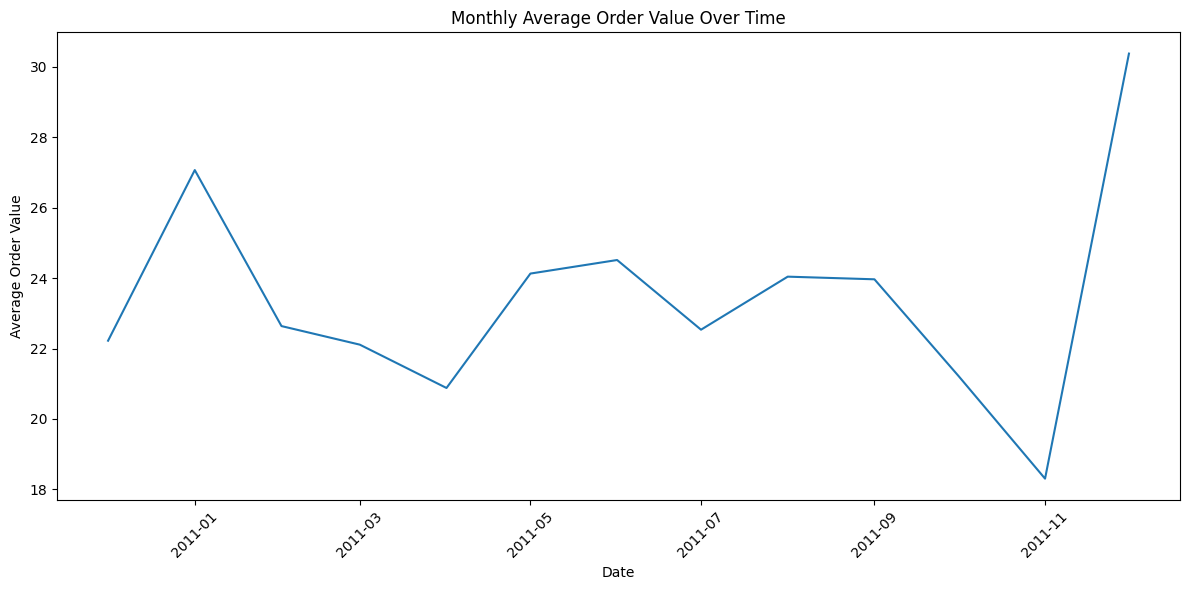

In [49]:
from pyspark.sql.functions import avg
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pyspark.sql.functions import col

# Calculate average total price per month and year and collect into pandas
monthly_avg_order_value = df_clean.groupBy("Year", "Month").agg(avg("TotalPrice").alias("AverageOrderValue")).orderBy("Year", "Month").collect()
monthly_avg_order_value_pd = pd.DataFrame(monthly_avg_order_value, columns=["Year", "Month", "AverageOrderValue"])
monthly_avg_order_value_pd["Date"] = pd.to_datetime(monthly_avg_order_value_pd["Year"].astype(str) + "-" + monthly_avg_order_value_pd["Month"].astype(str))

# Plot time series of monthly average order value
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_avg_order_value_pd, x="Date", y="AverageOrderValue")
plt.title("Monthly Average Order Value Over Time")
plt.xlabel("Date")
plt.ylabel("Average Order Value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Perform in-depth analysis of returns

### Subtask:
Analyze the characteristics of returned items, such as the most frequently returned products and the reasons for returns if available in the data.


**Reasoning**:
Filter the original DataFrame to get returned items, group by description, sum the quantities, order by sum of quantity in ascending order, and show the top 10.



In [50]:
from pyspark.sql.functions import col

df_raw = spark.read.csv("online_retail.csv", header=True, inferSchema=True)

df_returns = df_raw.filter(col("InvoiceNo").startswith("C"))
returned_item_quantities = df_returns.groupBy("Description")\
    .sum("Quantity")\
    .orderBy(col("sum(Quantity)").asc())

returned_item_quantities.show(10, truncate=False)

+-----------------------------------+-------------+
|Description                        |sum(Quantity)|
+-----------------------------------+-------------+
|PAPER CRAFT , LITTLE BIRDIE        |-80995       |
|MEDIUM CERAMIC TOP STORAGE JAR     |-74494       |
|ROTATING SILVER ANGELS T-LIGHT HLDR|-9376        |
|Manual                             |-4066        |
|FAIRY CAKE FLANNEL ASSORTED COLOUR |-3150        |
|PINK BLUE FELT CRAFT TRINKET BOX   |-2617        |
|WHITE HANGING HEART T-LIGHT HOLDER |-2578        |
|GIN + TONIC DIET METAL SIGN        |-2030        |
|HERB MARKER BASIL                  |-1527        |
|FELTCRAFT DOLL MOLLY               |-1447        |
+-----------------------------------+-------------+
only showing top 10 rows


In [51]:
import pandas as pd

df_sample = df.head(10000)
df_sample = pd.DataFrame(df_sample, columns=df.columns) # Convert list of Rows to pandas DataFrame
df_sample.to_csv("online_retail_sample.csv", index=False)
print(" Saved sample as 'online_retail_sample.csv'")

 Saved sample as 'online_retail_sample.csv'


In [53]:
plt.savefig("monthly_revenue.png")  # Example


<Figure size 640x480 with 0 Axes>

/tmp/ipython-input-542617250.py:23: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-542617250.py:24: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig("monthly_revenue.png")
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


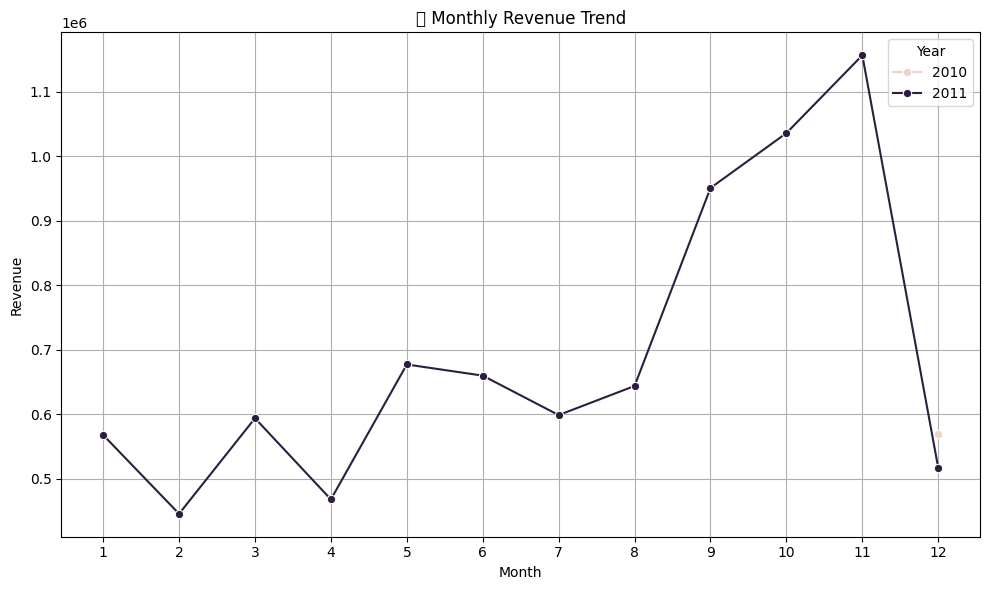

In [52]:
from pyspark.sql.functions import month, year, sum
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pyspark.sql.functions import col


monthly_rev = df_clean.withColumn("Month", month("InvoiceDate")) \
                .withColumn("Year", year("InvoiceDate")) \
                .groupBy("Year", "Month") \
                .agg(sum("TotalPrice").alias("Revenue")) \
                .orderBy("Year", "Month")

monthly_pd = monthly_rev.toPandas()

plt.figure(figsize=(10, 6))
sns.lineplot(x='Month', y='Revenue', hue='Year', data=monthly_pd, marker='o')
plt.title("📈 Monthly Revenue Trend")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.xticks(range(1, 13))
plt.grid(True)
plt.tight_layout()
plt.savefig("monthly_revenue.png")
plt.show()

/tmp/ipython-input-2250856763.py:16: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2250856763.py:17: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  plt.savefig("top_returns.png")
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


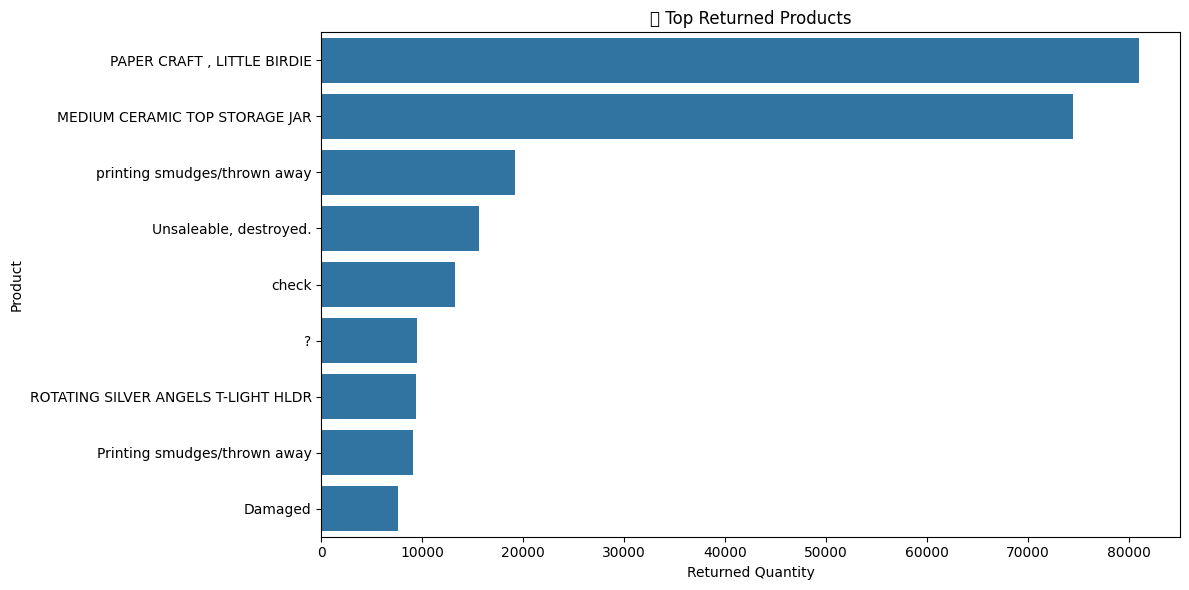

In [54]:
from pyspark.sql.functions import abs

returned_items = df.filter(df["Quantity"] < 0) \
                   .groupBy("Description") \
                   .agg(abs(sum("Quantity")).alias("ReturnQty")) \
                   .orderBy("ReturnQty", ascending=False) \
                   .limit(10)

returned_pd = returned_items.toPandas()

plt.figure(figsize=(12, 6))
sns.barplot(x='ReturnQty', y='Description', data=returned_pd)
plt.title("🔁 Top Returned Products")
plt.xlabel("Returned Quantity")
plt.ylabel("Product")
plt.tight_layout()
plt.savefig("top_returns.png")
plt.show()


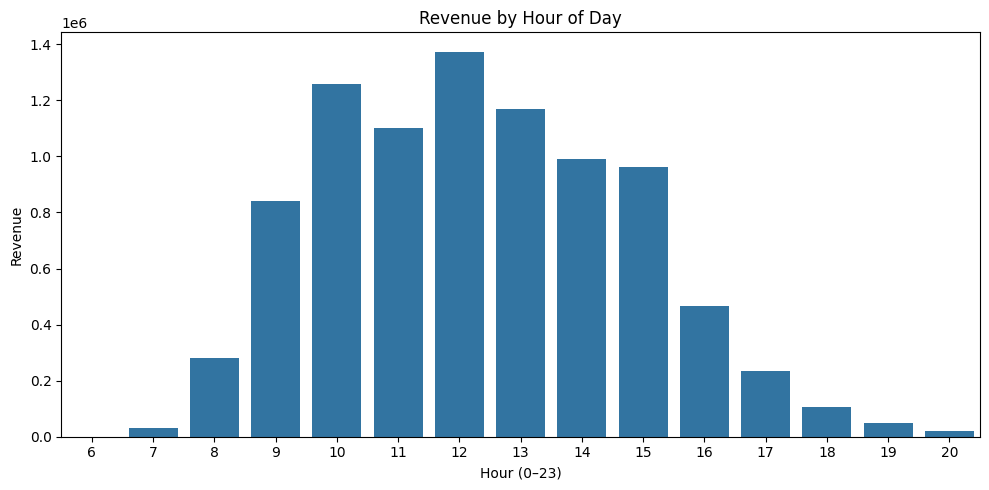

In [55]:
from pyspark.sql.functions import hour, sum

hourly_sales = df_clean.groupBy("Hour") \
                           .agg(sum("TotalPrice").alias("Revenue")) \
                           .orderBy("Hour")

hourly_sales_pd = hourly_sales.toPandas()

plt.figure(figsize=(10, 5))
sns.barplot(x='Hour', y='Revenue', data=hourly_sales_pd)
plt.title("Revenue by Hour of Day")
plt.xlabel("Hour (0–23)")
plt.ylabel("Revenue")
plt.tight_layout()
plt.savefig("revenue_by_hour.png")
plt.show()